
<h1 style="text-align:center">Gaussian Process Regression</h1>

<div class="alert alert-success">
<b>Hugo Barbaroux</b>
<br>
Python version: <b>3.6.5</b>
<br>
Jupyter Notebook version: <b>5.5.0</b>
</div>

In [810]:
# Computational imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

# Use of the seaborn style for graphics
import seaborn as sb
sb.set()

# Keep the warnings quiet
import warnings
warnings.filterwarnings('ignore')

# Set the figure size
plt.rcParams['figure.figsize'] = (15.0, 8.0)

## Aims
<div class="alert alert-info">
<ul> 
<li>To sample from a Gaussian process prior distribution.
<li>To implement Gaussian process inference for regression.
<li>To use the above to observe samples from a Gaussian process posterior distribution.
<li>To evaluate how different hyperparameter settings impact model quality.
<li> To investigate different kernel functions and parameter optimisation strategies.
</ul>
</div>

## Introduction
<div class="alert alert-info">
Gaussian processes (henceforth GPs) achieve greater flexibility over parametric models by imposing a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs allows one to access a certain (infinite) set of functions, preference can be expressed using a prior over functions. This allows greater freedom in representing data dependencies, thus enabling the construction of better-suited models. Here, for the sake of clarity, we shall focus on univariate data, which allows for better visualisation of the GP model. Nonetheless, the code implemented can be very easily extended to handle multi-dimensional inputs.
</div>

## Sampling from the GP Prior
<div class="alert alert-info">
We shall consider a one-dimensional regression problem, whereby the inputs x are transformed by
a function $f(x) = sin(exp(0.03 * x))$. 
</div>

In [811]:
def f(x) :
    return np.sin(np.exp(0.03*x))

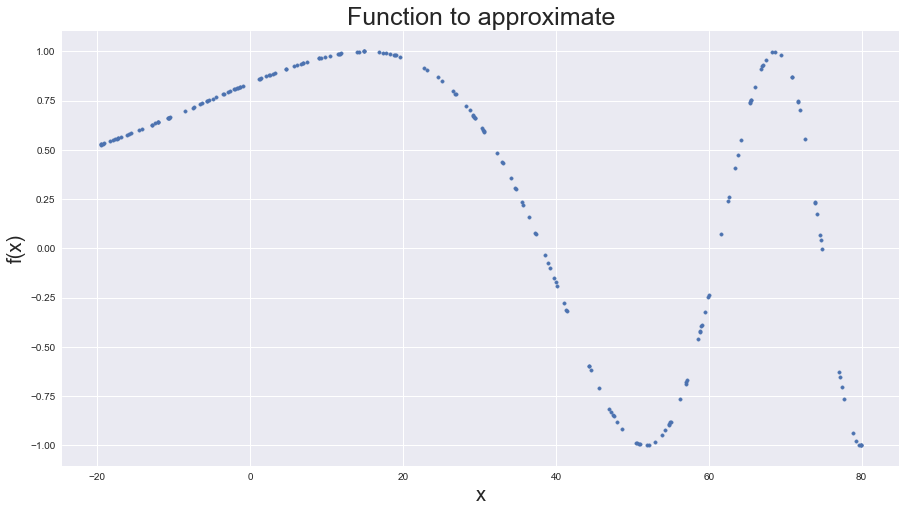

In [812]:
x = np.random.uniform(-20,80,200)
y = np.array([f(x_i) for x_i in x])

plt.scatter(x,y,marker='.')

plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.title("Function to approximate", fontsize=25)

plt.show()

<div class="alert alert-info">
Recall that since GPs are non-parametric, we define a prior distribution over functions (models), specified as a multivariate Gaussian distribution $p(f) = N (\mu, \Sigma)$.

Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\mu = 0$. The covariance matrix of the distribution, $\Sigma$, may then be computed by evaluating the covariance between the input points. Here, we shall consider the widely used squared-exponential (RBF) covariance (also referred to as the kernel function), which is defined between two points as: 

$$k(x, x') = \sigma_f^2 \exp \Big( -\dfrac {(x-x')^2}{2l^2} \Big). $$

This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma_f^2$ . Given that the true function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma_n^2$ , to the diagonal entries of the resulting kernel matrix, $K$, such that

$$\mathbf{K_y} = \mathbf{K }+ \sigma_n^2\mathbf{I}.$$
</div>


In [813]:
def compute_kernel(x1, x2, lengthscale, variance):
    return variance*np.exp( ((x1-x2)**2) / (-2*(lengthscale**2)) )

def compute_matrix_kernel(x1, x2, lengthscale, variance, noise=False) :
    K = np.array([[compute_kernel(i, j, lengthscale, variance) for i in x1] for j in x2])
    
    if noise :
        return K + noise*np.eye(len(K))
    else :
        return K

<div class="alert alert-info">
Assuming a zero-mean prior, and using the kernel matrix constructed with `compute_kernel()` for input points x, we can sample from the prior distribution using the numpy `multivariate_normal()` function.
</div>

In [1015]:
def plot_function_sampling(lengthscale,variance,noise,nbr_samplings,mu) :
    ''' Plot samplings of a gaussian distribution '''
    
    K = compute_matrix_kernel(x,x,lengthscale,variance,noise)
    R = np.random.multivariate_normal(mu,K,size=nbr_samplings)
    
    plt.scatter(x,y,marker='o',color='black')
    
    for i in range(4) :
        plt.scatter(x,R[i],marker='.')

    plt.xlabel("x", fontsize=20)
    plt.ylabel("f(x)", fontsize=20)
    plt.title("Lengthscale {}, Variance {}".format(lengthscale,variance), fontsize=25)

    plt.show()

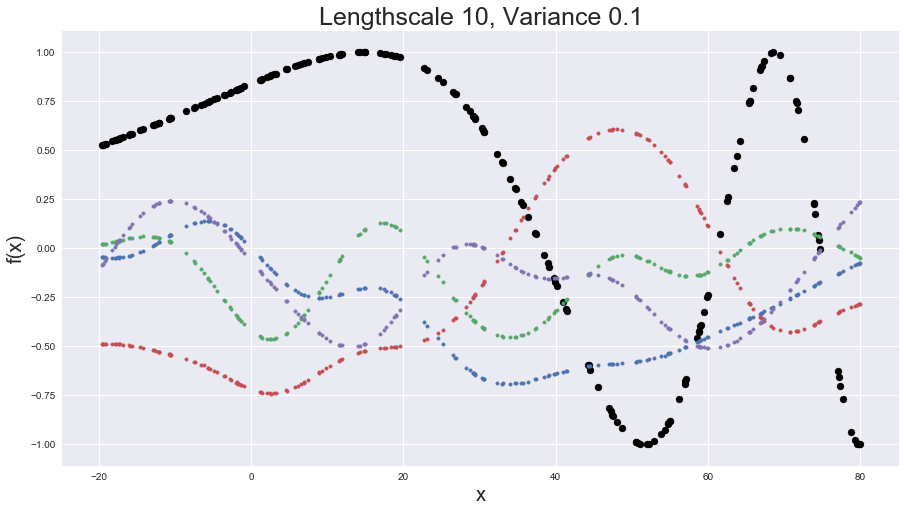

In [815]:
lengthscale = 10
variance = 0.1
noise = 10**(-6)
nbr_samplings = 4
mu = np.zeros(y.shape)

plot_function_sampling(lengthscale,variance,noise,nbr_samplings,mu)

<div class="alert alert-info">
 In order to better understand the role of the hyperparameters, we can observe how altering the kernel parameters impacts the shape of the prior samples.</div>

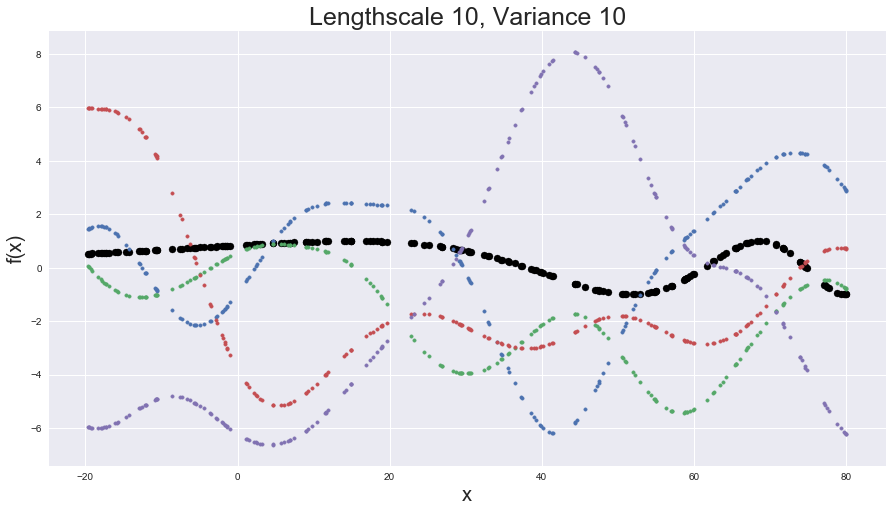

In [816]:
lengthscale = 10
variance = 10

plot_function_sampling(lengthscale,variance,noise,nbr_samplings,mu)

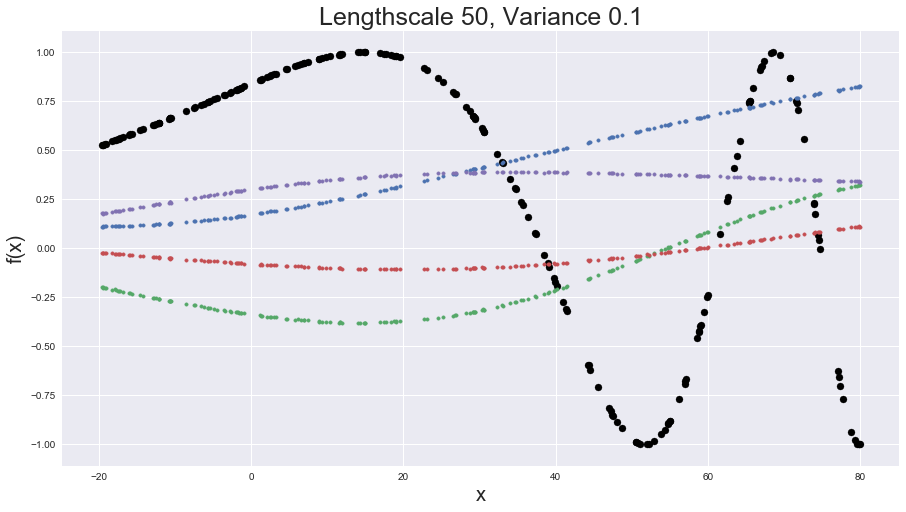

In [817]:
lengthscale = 50
variance = 0.1

plot_function_sampling(lengthscale,variance,noise,nbr_samplings,mu)

<div class="alert alert-success">
We can easily see that $l$ has an impact on the curve frequency, while $\sigma_f^2$ impacts the values' range of the function.
</div>

## GP Inference
<div class="alert alert-info">
Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe $N$ points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The combination of the prior and the likelihood of the observed data leads to the posterior distribution over functions.
</div>

<div class="alert alert-info">

`gp_inference` evaluates the posterior GP mean and variance using the following equations.
<br><br>
<b>Note</b>: As matrix inversions can be both numerically troublesome and slow to compute, we shall avoid computing them directly by instead considering Cholesky decompositions for solving linear systems. Read more about Cholesky decompositions for GPs by consulting Appendix A.4 of <a target="_blank" href="http://www.gaussianprocess.org/gpml/">Gaussian Processes for Machine Learning (Rasmussen and Williams, 2005)</a> - available online!<br><br>

The complete pseudo-code for the following procedure is provided in Algorithm 2.1 from Chapter 2 of this same book, giving at the same time a formula for the evaluation of the log likelihood.
</div>

From theory, mean and variance of the posterior are:
$$
\Sigma_p=k_{**}-\mathbf{k}_*^T\mathbf{K_y}^{-1}\mathbf{k}_*
$$
$$
\mu_p=\mathbf{k}_*^T\mathbf{K_y}^{-1}\mathbf{t}
$$
where, if $\mathbf{x_*}$ is a sample to predict and $\mathbf{x}=\mathbf{x_1},\dots,\mathbf{x_N}$ the observated samples, $\mathbf{K_y}$ is the noisy kernel matrix, $(\mathbf{k}_*)_i=k(\mathbf{x_*},\mathbf{x_i})$ and $k_{**}=k(\mathbf{x_*},\mathbf{x_*})$.
<br><br>
As stated before, we shall use the Cholesky decomposition of $\mathbf{K_y}$ in order to compute $\alpha=\mathbf{K_y}^{-1}\mathbf{k}_*$. If this decomposition is $\mathbf{K_y}^{-1}=\mathbf{L}\mathbf{L^\mathsf{T}}$, then $\alpha=\mathbf{L^\mathsf{T}} * (\mathbf{L} * \mathbf{t})$, where $u=A*b$ if $Au=b$.
We can also use this trick to compute the mean.

Finally, the formula of the log likelihood is:
$$
\Lambda=-\frac{1}{2}\mathbf{t}^\mathsf{T}\mathbf{K_y}^{-1}\mathbf{t}-\frac{1}{2}\log\left|\mathbf{K_y}\right|-\frac{N}{2}\log(2\pi)
$$
Using the Cholesky decomposition, we can simplify this by:
$$
\Lambda=-\frac{1}{2}\mathbf{t}^\mathsf{T}\alpha-\sum_iL_{ii}-\frac{N}{2}\log(2\pi)
$$

In [830]:
def gp_inference(obs_x, obs_t, x_new, lengthscale, variance, noise):

    N = np.shape(obs_x)[0]
    
    # compute kernel
    K_y = compute_corrupted_kernel(obs_x,obs_x,lengthscale,variance,noise)
    
    # compute the Cholesky decomposition of K_y
    K_chol = np.linalg.cholesky(K_y)
    
    # compute alpha
    alpha = scipy.linalg.solve_triangular(np.transpose(K_chol),scipy.linalg.solve_triangular(K_chol,obs_t,lower=True),lower=False)
    
    # compute the covariance between the training and test data
    K_obs_pred = compute_corrupted_kernel(x_new,obs_x,lengthscale,variance)
    
    # compute the covariance for the test data
    K_pred = compute_corrupted_kernel(x_new,x_new,lengthscale,variance)
    
    # compute the posterior mean
    posterior_m = np.dot(np.transpose(K_obs_pred), alpha)
    
    beta = scipy.linalg.solve_triangular(np.transpose(K_chol),scipy.linalg.solve_triangular(K_chol,K_obs_pred,lower=True),lower=False)
    posterior_v = K_pred - np.transpose(K_obs_pred).dot(beta)

    log_lik = -0.5*np.transpose(obs_t).dot(alpha) - np.sum(np.log(np.diag(K_chol))) -0.5*N*np.log(2*np.pi)
       
    return posterior_m, posterior_v, log_lik

## Sampling from the  GP Posterior<br>

<div class="alert alert-info">
Now that we have computed the posterior mean and variance, we can sample from the GP distribution a plot additionaly the standard deviation of the GP inference.
</div>

In [898]:
x = np.linspace(-20,80,200)
y = np.array([f(x_i) for x_i in x])

nbr_obs = 10
obs_x = np.random.choice(x, nbr_obs, replace=False)
obs_t = np.array([f(x_i) for x_i in obs_x])

In [899]:
lengthscale = 5
variance = 2
noise = 10**(-3)
nbr_samplings = 50

In [1016]:
def posterior_sampling(obs_x,obs_t,x,lengthscale,variance,noise,nbr_samplings,title=False) :
    ''' Compute the GP posterior and sample from it '''
    
    # Computation of the posterior parameters
    posterior_m, posterior_v, log_lik = gp_inference(obs_x,obs_t,x,lengthscale,variance,noise)
    
    # Adding the noise to the posterior variance
    posterior_v += noise*np.eye(len(x))
    posterior_std = np.sqrt(np.diag(posterior_v))
    
    # Sampling from the posterior distribution
    R = np.random.multivariate_normal(posterior_m,posterior_v, size=nbr_samplings)
    
    print("Negative log likelihood = {}".format(-log_lik))
    
    for i in range(nbr_samplings) :
        plt.scatter(x, R[i], marker='.', s=8)
        
    plt.scatter(obs_x, obs_t, color='red')
    plt.errorbar(x, y, yerr=posterior_std, fmt='.')
    plt.scatter(x, y, marker='.', color='black', s=20)

    plt.xlabel("x", fontsize=20)
    plt.ylabel("f(x)", fontsize=20)
    if title :
        plt.title(title, fontsize=25)
    else :
        plt.title("Sampling from lengthscale {}, variance {} with {} known points".format(lengthscale,variance,len(obs_x)), fontsize=25)

    plt.show()

Negative log likelihood = 7.7547838614066436


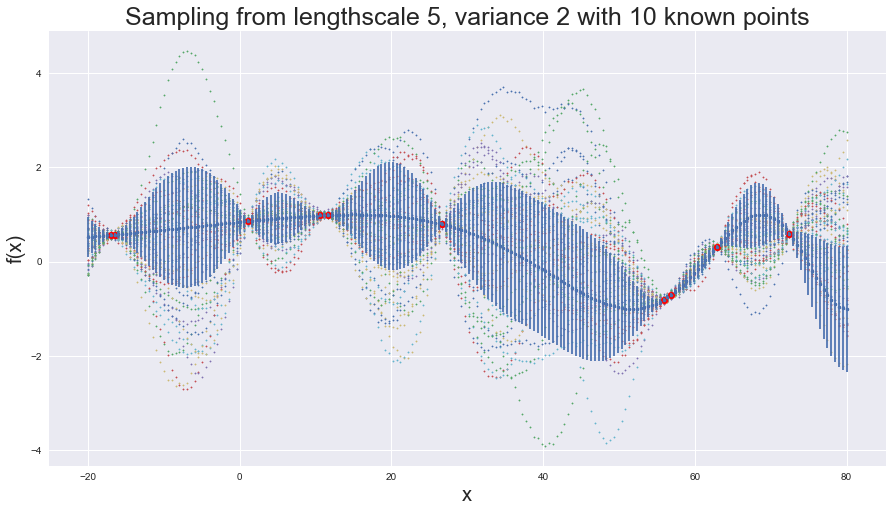

In [901]:
posterior_sampling(obs_x,obs_t,x,lengthscale,variance,noise,nbr_samplings)

## Parameter Optimisation using Gradient Descent
<br>
<div class="alert alert-info">
Optimisation of the hyperparameters of the model by minimising the negative log likelihood of the model.
<br><br>
<b>Pro tip:</b> Note that the parameters $l$ and $\sigma_f^2$ are always expected to be positive. It is possible that the optimisation algorithm attempts to evaluate the log-likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues. In that case, a commonly-used technique to enforce this condition is to work with a transformed version of covariance parameters using the logarithm transformation. In particular, define $\psi_l = log(l)$, $\psi_f = log(\sigma_f^2 )$, and optimise with respect to the $\psi$ parameters. The optimisation problem in the transformed space is then unbounded, and the gradient of the log-likelihood should be computed with respect to the $\psi$ parameters.
</div>

The general formula for computing the derivative is given below:<br>
$$
\frac{\partial\text{NLL}}{\partial\theta_i} = - \frac{1}{2} \textbf{Tr} \left( \mathbf{K_y}^{-1} \frac{\partial \mathbf{K_y}}{\partial \theta_i} \right) + \frac{1}{2} \textbf{t}^{T} \mathbf{K_y}^{-1} \frac{\partial \mathbf{K_y}}{\partial \theta_i} \mathbf{K_y}^{-1} \textbf{t}.
$$<br>
where
$$
\frac{\partial \mathbf{K_y}}{\partial l} = \sigma_f^2 \exp \left( -\dfrac {(x-x')^2}{2l^2} \right)\left( \dfrac {(x-x')^2}{l^3} \right)
$$
$$
\frac{\partial \mathbf{K_y}}{\partial \sigma_f^2} = \exp \left( -\dfrac {(x-x')^2}{2l^2} \right) = \frac{1}{\sigma_f^2}\mathbf{K}
$$

In [1002]:
x_gd = np.linspace(-20,80,200)
y_gd = np.array([f(x_i) for x_i in x_gd])

nbr_obs_gd = 20
obs_x_gd = np.random.choice(x_gd, nbr_obs_gd, replace=False)
obs_t_gd = np.array([f(x_i) for x_i in obs_x_gd])

In [1020]:
alpha = 0.1 # learning rate
nbr_max_iter = 1000 # Nb max of iterations
eps = 0.00001 # stop condition

In [998]:
lengthscale_init = 5 # start point
variance_init = 5
noise_init = 10**(-6)

Negative log likelihood = 8.265387917048702


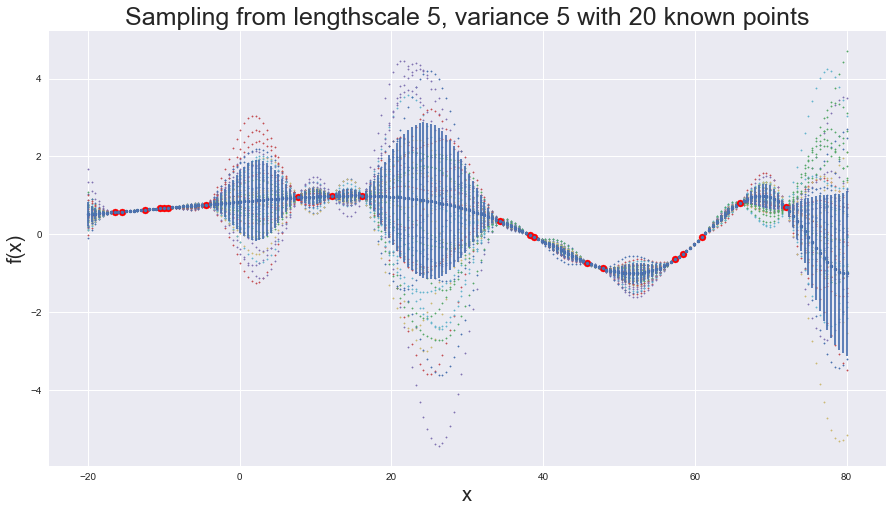

In [1013]:
posterior_sampling(obs_x_gd,obs_t_gd,x_gd,lengthscale_init,variance_init,noise_init,nbr_samplings)

In [1019]:
def partial_derivative(obs_x,obs_t,lengthscale,variance,noise,deriv) :
    ''' Computation of the partial derivative of the negative log likelihood according to the previous formulae '''
    
    K = compute_corrupted_kernel(obs_x,obs_x,lengthscale,variance)
    K_noise = K + noise*np.eye(len(obs_x))
    K_chol = np.linalg.cholesky(K_noise)
    alpha = scipy.linalg.solve_triangular(np.transpose(K_chol),scipy.linalg.solve_triangular(K_chol,obs_t,lower=True),lower=False)
    
    if deriv == 'lengthscale' :
        K_modif = [[(K[i,j]*(obs_x[i]-obs_x[j])**2) / (lengthscale**3) for i in range(len(obs_x))] for j in range(len(obs_t))]
        alpha_modif = scipy.linalg.solve_triangular(np.transpose(K_chol),scipy.linalg.solve_triangular(K_chol,K_modif,lower=True),lower=False)
        return 0.5*np.trace(alpha_modif) - 0.5*(np.transpose(obs_t).dot(alpha_modif)).dot(alpha)
    
    elif deriv == 'variance' :
        alpha_K = scipy.linalg.solve_triangular(np.transpose(K_chol),scipy.linalg.solve_triangular(K_chol,K,lower=True),lower=False)
        return 0.5*np.trace((1/variance)*alpha_K) - (1/(2*variance))*(np.transpose(obs_t).dot(alpha_K)).dot(alpha)

In [1021]:
def gradient_descent(obs_x,obs_t,x,lengthscale,variance,noise,eps,nbr_max_iter,infos=False) :
    ''' Optimization of the hyperparameters using gradient descent'''
    
    lik_diff = eps + 10
    nbr_iter = 0
    lengthscale_0,variance_0,noise_0 = lengthscale,variance,noise
    log_lik_0 = -gp_inference(obs_x,obs_t,x,lengthscale_0,variance_0,noise_0)[2]
    tmp_log_lik = log_lik_0

    if infos :
        print("Epoch {} --- Negative Log Likelihood = {}".format(0,log_lik_0))

    while lik_diff > eps and nbr_iter < nb_max_iter:
    
        tmp_lengthscale = lengthscale_0 - alpha * partial_derivative(obs_x,obs_t,lengthscale_0,variance_0,noise_0,'lengthscale')
        tmp_variance = variance_0 - alpha * partial_derivative(obs_x,obs_t,lengthscale_0,variance_0,noise_0,'variance')
    
        lengthscale_0 = tmp_lengthscale
        variance_0 = tmp_variance
    
        log_lik_0 = -gp_inference(obs_x,obs_t,x,lengthscale_0,variance_0,noise_0)[2]
        nbr_iter += 1
        
        if infos :
            if not(nbr_iter % 5) :
                print("Epoch {} --- Negative Log Likelihood = {}".format(nbr_iter,log_lik_0))
            if not(nbr_iter % 50) :
                print("Lengthscale = {}\nVariance = {}\nNoise = {}".format(lengthscale_0,variance_0,noise_0))
        
        lik_diff = abs( tmp_log_lik - log_lik_0 )
        tmp_log_lik = log_lik_0
    
    print("\nFINAL PARAMS:\n\tLengthscale = {}\n\tVariance = {}\n\tNoise = {}".format(lengthscale_0,variance_0,noise_0))
    
    return lengthscale_0,variance_0,noise_0

In [1005]:
lengthscale_final,variance_final,noise_final = gradient_descent(obs_x_gd,
                                                                  obs_t_gd,
                                                                  x_gd,
                                                                  lengthscale_init,
                                                                  variance_init,
                                                                  noise_init,
                                                                  eps,
                                                                  nbr_max_iter,
                                                                  infos=True)

Epoch 0 --- Negative Log Likelihood = 8.265387917048702
Epoch 5 --- Negative Log Likelihood = -10.464562859361763
Epoch 10 --- Negative Log Likelihood = -23.020436183813544
Epoch 15 --- Negative Log Likelihood = -25.89693853516618
Epoch 20 --- Negative Log Likelihood = -26.018615906180962
Epoch 25 --- Negative Log Likelihood = -26.024576605955673
Epoch 30 --- Negative Log Likelihood = -26.029778196234176
Epoch 35 --- Negative Log Likelihood = -26.035415666459073
Epoch 40 --- Negative Log Likelihood = -26.04150863363413
Epoch 45 --- Negative Log Likelihood = -26.048061065508413
Epoch 50 --- Negative Log Likelihood = -26.05506721194446
Lengthscale = 11.207402928475124
Variance = 1.9418085129136318
Noise = 1e-06
Epoch 55 --- Negative Log Likelihood = -26.06250940102455
Epoch 60 --- Negative Log Likelihood = -26.07035575898812
Epoch 65 --- Negative Log Likelihood = -26.078558182567924
Epoch 70 --- Negative Log Likelihood = -26.087050864148615
Epoch 75 --- Negative Log Likelihood = -26.0957

Negative log likelihood = -26.18896690033319


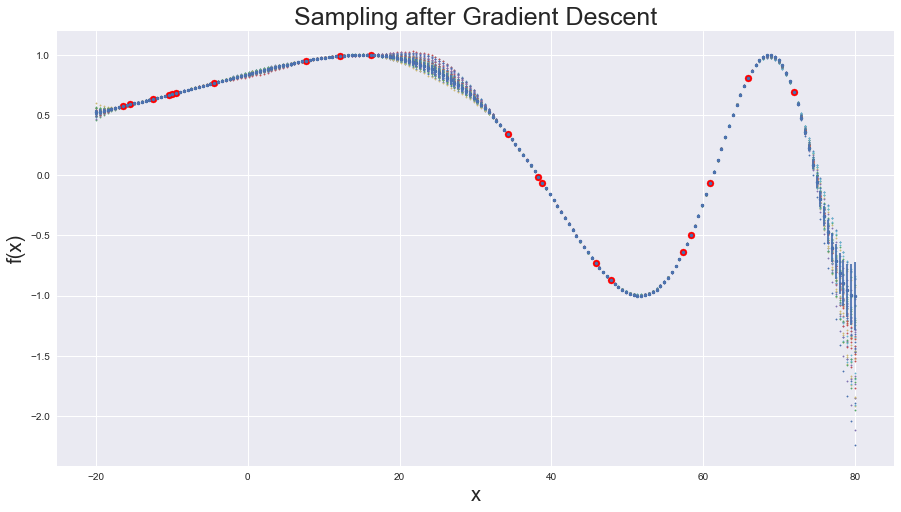

In [1009]:
posterior_sampling(obs_x_gd,obs_t_gd,x_gd,lengthscale_final,variance_final,noise_final,nbr_samplings,title="Sampling after Gradient Descent")

## Alternative Kernel Functions
<div class="alert alert-info">
In this notebook, we have focused exclusively on the RBF kernel.
However, the choice of kernel function (along with its associated parameters) can have a significant effect on the overall Gaussian process model.
Choosing the best kernel to fit the data is no simple task, and is a pertinent problem in many applied domains.<br>

A brief discussion on this problem may be found here: <a target="_blank" href="https://www.cs.toronto.edu/~duvenaud/cookbook/">Kernel Cookbook</a>. 